In [1]:
import pandas as pd

In [2]:
# Load the cbp-landsat dataset
path = '/efs/sarp/resources/coding-data-help/cbp-landsat-matchup.csv'
df = pd.read_csv(path)
df.columns = df.columns.str.strip()
df.head()

,Unnamed: 0,EventId,Station,SampleDate,SampleTime,Depth,SampleType,SampleReplicateType,Parameter,Qualifier,...,coastal_n,blue_n,green_n,red_n,nir08_n,datetime,eo:cloud_cover,proj:epsg,view:sun_azimuth,view:sun_elevation
0,2,394409,LE5.1,2013-10-01,10:00:00,1,D,S1,CHLA,NaN,...,0,0,0,0,0,2013-09-28T15:48:43.124917Z,89.5,32618,153.472907,46.995058
1,541,394409,LE5.1,2013-10-01,10:00:00,1,D,S1,DIN,NaN,...,0,0,0,0,0,2013-09-28T15:48:43.124917Z,89.5,32618,153.472907,46.995058
2,1098,394409,LE5.1,2013-10-01,10:00:00,1,ISM,M1,DO,NaN,...,0,0,0,0,0,2013-09-28T15:48:43.124917Z,89.5,32618,153.472907,46.995058
3,1802,394409,LE5.1,2013-10-01,10:00:00,1,D,S1,DON,NaN,...,0,0,0,0,0,2013-09-28T15:48:43.124917Z,89.5,32618,153.472907,46.995058
4,2356,394409,LE5.1,2013-10-01,10:00:00,1,D,S1,DOP,NaN,...,0,0,0,0,0,2013-09-28T15:48:43.124917Z,89.5,32618,153.472907,46.995058


In [3]:
import numpy as np

# Filter out only the CHLa measurements
df_chla = df.copy()
df_chla = df_chla.query("Parameter == 'CHLA'")

# Drop rows with negative MeasureValue
df_chla = df_chla[df_chla['coastal'] > 0]

df_chla['log_chla'] = np.log(df_chla['MeasureValue'])

df_chla.to_csv("CHLA.csv", index=False)

df_chla.head()

,Unnamed: 0,EventId,Station,SampleDate,SampleTime,Depth,SampleType,SampleReplicateType,Parameter,Qualifier,...,blue_n,green_n,red_n,nir08_n,datetime,eo:cloud_cover,proj:epsg,view:sun_azimuth,view:sun_elevation,log_chla
28,3,394410,LE5.1,2013-11-06,09:55:00,1,D,S1,CHLA,NaN,...,81,81,81,81,2013-11-08T15:42:24.810989Z,2.30,32618,161.366555,33.702104,0.928219
56,5,394671,TF5.6,2014-01-15,12:30:00,1,D,S1,CHLA,NaN,...,81,81,81,81,2014-01-18T15:47:59.659437Z,13.56,32618,155.542397,28.167661,0.494696
82,6,394496,TF5.6,2013-12-03,11:50:00,1,D,S1,CHLA,NaN,...,81,81,81,81,2013-12-01T15:48:28.292876Z,9.76,32618,161.511960,28.391523,0.891998
246,21,395379,TF5.6,2015-01-06,11:30:00,1,D,S1,CHLA,NaN,...,81,81,81,81,2015-01-05T15:46:53.790263Z,6.92,32618,157.357920,26.486612,1.088562
276,22,395380,TF5.6,2015-02-03,12:00:00,1,D,S1,CHLA,NaN,...,81,81,81,81,2015-02-06T15:46:45.651144Z,7.54,32618,152.228344,32.290358,0.688135


In [4]:
!pip install mlxtend

  Using cached mlxtend-0.22.0-py2.py3-none-any.whl (1.4 MB)


### PCA 

In [5]:
import pandas as pd
import numpy as np
from joblib import dump, load
from sklearn.decomposition import PCA
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error, r2_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# Define the features X and the target variable y
ref = np.stack([df_chla['coastal'], df_chla['blue'], df_chla['green'],
             df_chla['red'], df_chla['nir08']], axis=1)
y = df_chla['log_chla']

# Perform PCA on the ref variable
pca = PCA()
pca.fit(ref)
ref_pca = pca.transform(ref)
scores = ref_pca[:]  
X = np.hstack((scores, scores**2))

# Add a constant column to X for the intercept term
X = sm.add_constant(X)

dump(pca, 'PCA.joblib')

# Perform stepwise feature selection
inmodel = []
best_aic = np.inf
while True:
    remaining = list(set(range(X.shape[1])) - set(inmodel))
    best_feature = None
    for feature in remaining:
        model = sm.OLS(y, X[:, inmodel + [feature]])
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_feature = feature
    if best_feature is not None:
        inmodel.append(best_feature)
    else:
        break

# Fit the final OLS model using the selected features
final_X = X[:, inmodel]
final_model = sm.OLS(y, final_X)
final_results = final_model.fit()

dump(final_results, 'OLS.joblib')

# Get the model coefficients
b = final_results.params

# Get the standard errors
se = final_results.bse

# Get the p-values
pval = final_results.pvalues

# Print the results
print("Model Coefficients:")
print(b)
print("\nStandard Errors:")
print(se)
print("\nP-values:")
print(pval)

Model Coefficients:
const         2.595083
x1           68.776804
x2          501.187174
x3        -1504.435013
x4      -229935.454715
x5          -16.681559
x6          -33.683075
dtype: float64

Standard Errors:
const        0.082081
x1           5.559255
x2          77.083036
x3         356.058154
x4       45582.519403
x5           7.335984
x6          23.759467
dtype: float64

P-values:
const    1.634050e-54
x1       5.068839e-22
x2       2.974778e-09
x3       5.203959e-05
x4       1.986337e-06
x5       2.506447e-02
x6       1.593349e-01
dtype: float64


In [6]:
inmodel

[0, 2, 5, 7, 10, 3, 6]

In [7]:
final_X.shape

(109, 7)

In [8]:
final_results.params

const         2.595083
x1           68.776804
x2          501.187174
x3        -1504.435013
x4      -229935.454715
x5          -16.681559
x6          -33.683075
dtype: float64

In [9]:
Yhat = final_results.predict(final_X)

# Calculate bias
bias = np.mean(y - Yhat)
print(f'Bias: {bias}')

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y, Yhat)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate R-squared
r2 = r2_score(y, Yhat)
print(f'R-squared: {r2}')

Bias: -9.3116136615809e-15
Mean Absolute Error (MAE): 0.46327212878189455
R-squared: 0.6330509290578077


### Metrics Table

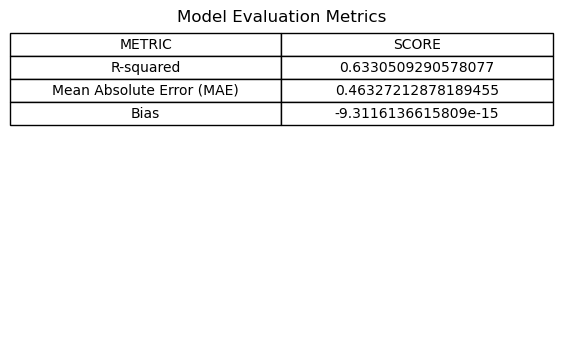

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate bias
bias = np.mean(y - Yhat)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y, Yhat)

# Calculate R-squared
r2 = r2_score(y, Yhat)

# Create a DataFrame to store the metrics and scores
metrics_df = pd.DataFrame(
    {
        'METRIC': ['R-squared', 'Mean Absolute Error (MAE)','Bias'],
        'SCORE': [r2, mae, bias]
    }
)

# Create the table figure
fig, ax = plt.subplots(figsize=(7, 4))  # Decrease the height of the figure
ax.axis('off')  # Turn off axis
ax.set_title('Model Evaluation Metrics', fontsize=12, pad=8)  # Reduce the padding for the title
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, loc='center',
                 cellLoc='center', bbox=[0, 0.7, 1, 0.3])  # Adjust bbox for table position

# Adjust cell font size for better readability
cell_font_size = 10  # Decrease the font size
for cell in table.properties()['children']:
    cell.set_fontsize(cell_font_size)

# Show the table
plt.show()

-9.3116136615809e-15


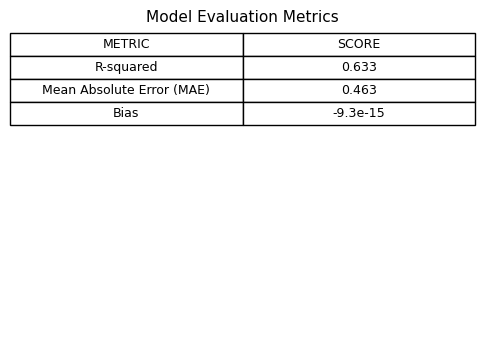

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate bias
bias = np.mean(y - Yhat)
print(bias)

# Calculate mean absolute error (MAE)
mae = mean_absolute_error(y, Yhat)

# Calculate R-squared
r2 = r2_score(y, Yhat)

# Round off the values to three decimal places
r2 = round(r2, 3)
mae = round(mae, 3)
bias = -9.3e-15


# Create a DataFrame to store the metrics and scores
metrics_df = pd.DataFrame(
    {
        'METRIC': ['R-squared', 'Mean Absolute Error (MAE)','Bias'],
        'SCORE': [r2, mae, bias]
    }
)

# Create the table figure
fig, ax = plt.subplots(figsize=(6, 4))  # Decrease the height of the figure
ax.axis('off')  # Turn off axis
ax.set_title('Model Evaluation Metrics', fontsize=11, pad=8)  # Reduce the padding for the title
table = ax.table(cellText=metrics_df.values, colLabels=metrics_df.columns, loc='center',
                 cellLoc='center', bbox=[0, 0.7, 1, 0.3])  # Adjust bbox for table position

# Adjust cell font size for better readability
cell_font_size = 9  # Decrease the font size
for cell in table.properties()['children']:
    cell.set_fontsize(cell_font_size)

# Show the table
plt.show()


### Figure

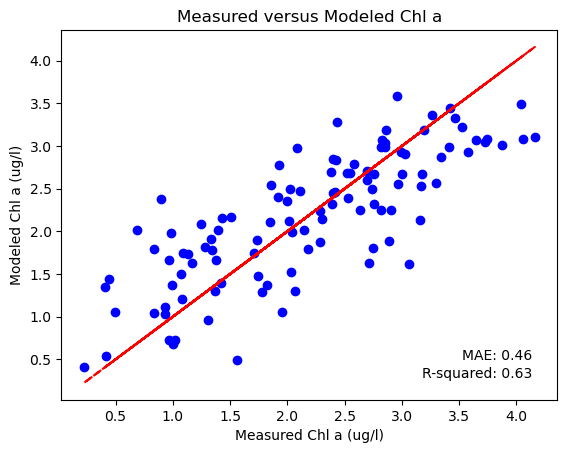

In [12]:
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.scatter(y, Yhat, color='b')
plt.plot(y, y, color='r', linestyle='--')
plt.xlabel('Measured Chl a (ug/l)')
plt.ylabel('Modeled Chl a (ug/l)')
plt.title('Measured versus Modeled Chl a')
# Add R-squared and MAE as text annotations
plt.text(0.95, 0.05, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='bottom')
plt.text(0.95, 0.1, f'MAE: {mae:.2f}', transform=plt.gca().transAxes,
         horizontalalignment='right', verticalalignment='bottom')
plt.show()

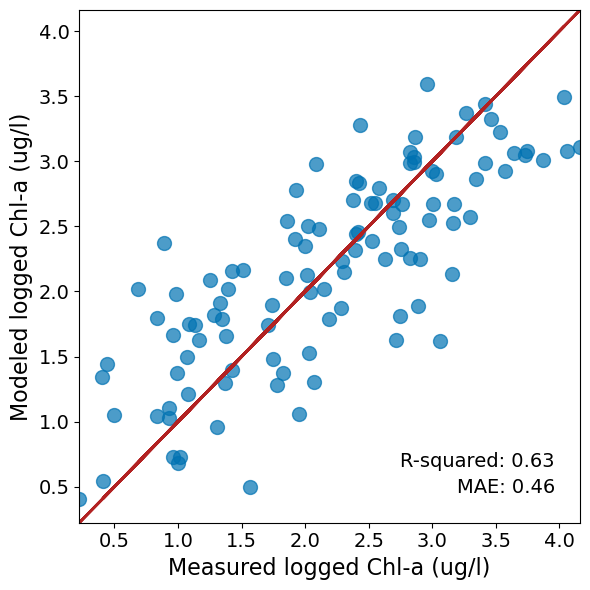

In [22]:
import matplotlib.pyplot as plt

# Define the custom color palette with color-blind friendly green-blue shades
custom_palette = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442']

# Scatter plot of actual vs predicted values with larger markers and transparency
plt.figure(figsize=(6, 6))  # Set a smaller square figure size
plt.scatter(y, Yhat, color=custom_palette[0], alpha=0.7, s=100)

# Add a diagonal line to represent ideal predictions
plt.plot(y, y, color='firebrick', linestyle='-', linewidth=2)

plt.xlabel('Measured logged Chl-a (ug/l)', fontsize=16)
plt.ylabel('Modeled logged Chl-a (ug/l)', fontsize=16)
#plt.title('Measured versus Modeled Chl-a', fontsize=18)

# Add R-squared as a text annotation in the bottom-right corner
plt.text(0.95, 0.1, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes,
          horizontalalignment='right', verticalalignment='bottom', fontsize=14)
plt.text(0.95, 0.05, f'MAE: {mae:.2f}', transform=plt.gca().transAxes,
          horizontalalignment='right', verticalalignment='bottom', fontsize=14)
#plt.text(0.95, 0.10, f'Bias: {bias:.2f}', transform=plt.gca().transAxes,
#          horizontalalignment='right', verticalalignment='bottom', fontsize=14)

# Customize tick font size for better readability
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Remove grid lines from the plot
plt.grid(False)

# Set x and y limits to be the same for a square plot
min_val = min(min(y), min(Yhat))
max_val = max(max(y), max(Yhat))
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Show the plot
plt.tight_layout()
plt.show()

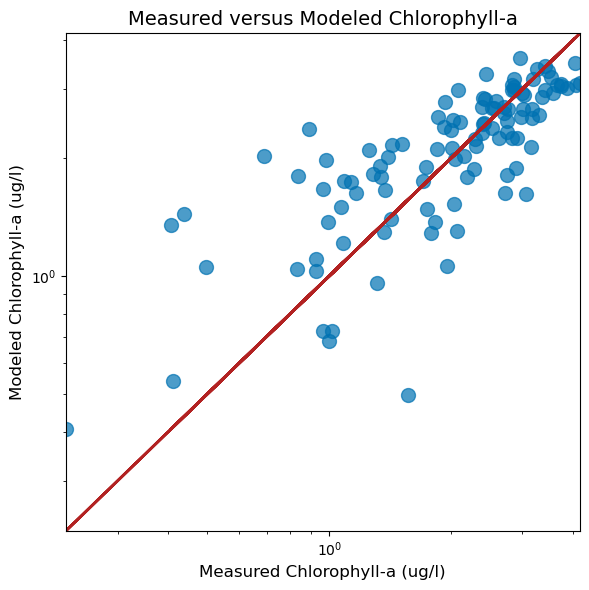

In [14]:
import matplotlib.pyplot as plt

# Define the custom color palette with color-blind friendly green-blue shades
custom_palette = ['#0072B2', '#009E73', '#D55E00', '#CC79A7', '#F0E442']

# Scatter plot of actual vs predicted values with larger markers and transparency
plt.figure(figsize=(6, 6))  # Set a smaller square figure size
plt.scatter(y, Yhat, color=custom_palette[0], alpha=0.7, s=100)

# Add a diagonal line to represent ideal predictions
plt.plot(y, y, color='firebrick', linestyle='-', linewidth=2)

plt.xlabel('Measured Chlorophyll-a (ug/l)', fontsize=12)
plt.ylabel('Modeled Chlorophyll-a (ug/l)', fontsize=12)
plt.title('Measured versus Modeled Chlorophyll-a', fontsize=14)

# Add R-squared as a text annotation in the bottom-right corner
# plt.text(0.95, 0.05, f'R-squared: {r2:.2f}', transform=plt.gca().transAxes,
#          horizontalalignment='right', verticalalignment='bottom', fontsize=12)
# plt.text(0.95, 0.10, f'MAE: {mae:.2f}', transform=plt.gca().transAxes,
#          horizontalalignment='right', verticalalignment='bottom', fontsize=14)

# Customize tick font size for better readability
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Remove grid lines from the plot
plt.grid(False)

# Set x and y limits to be the same for a square plot
min_val = min(min(y), min(Yhat))
max_val = max(max(y), max(Yhat))
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)

# Set the axis to a log scale
plt.xscale('log')
plt.yscale('log')

# Show the plot
plt.tight_layout()
plt.show()

### Residuals plots

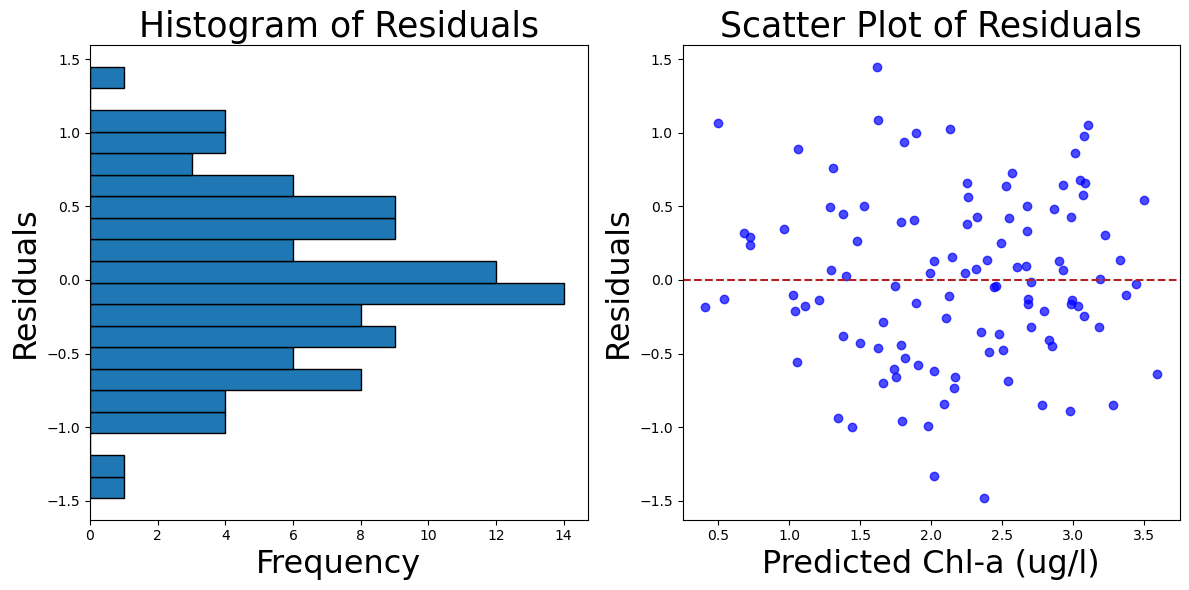

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y - Yhat

# Create the histogram of residuals
plt.figure(figsize=(12, 6))

# Histogram of residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, orientation='horizontal', edgecolor='black')
plt.ylabel('Residuals', fontsize=23)
plt.xlabel('Frequency', fontsize=23)
plt.title('Histogram of Residuals', fontsize=25)

# Scatter plot of residuals
plt.subplot(1, 2, 2)
plt.scatter(Yhat, residuals, color='b', alpha=0.7)
plt.axhline(y=0, color='firebrick', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Chl-a (ug/l)', fontsize=23)
plt.ylabel('Residuals', fontsize=23)
plt.title('Scatter Plot of Residuals', fontsize=25)

plt.tight_layout()
plt.show()

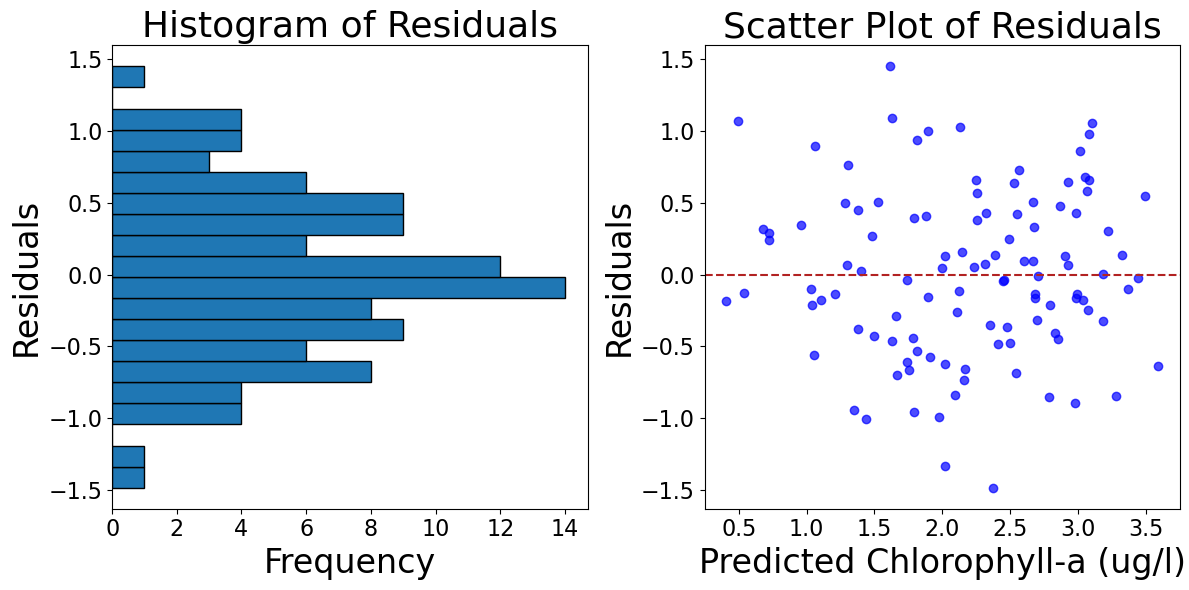

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the residuals
residuals = y - Yhat

# Create the histogram of residuals
plt.figure(figsize=(12, 6))

# Histogram of residuals
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=20, orientation='horizontal', edgecolor='black')
plt.ylabel('Residuals', fontsize=24)
plt.xlabel('Frequency', fontsize=24)
plt.title('Histogram of Residuals', fontsize=26)

# Increase the size of the ticks on the first subplot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Scatter plot of residuals
plt.subplot(1, 2, 2)
plt.scatter(Yhat, residuals, color='b', alpha=0.7)
plt.axhline(y=0, color='firebrick', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.xlabel('Predicted Chlorophyll-a (ug/l)', fontsize=24)
plt.ylabel('Residuals', fontsize=24)
plt.title('Scatter Plot of Residuals', fontsize=26)

# Increase the size of the ticks on the second subplot
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.tight_layout()
plt.show()

### PCA Normalised 

In [17]:
# import pandas as pd
# import numpy as np
# from sklearn.decomposition import PCA
# import statsmodels.api as sm
# from sklearn.metrics import mean_absolute_error, r2_score
# from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# # Define the features X and the target variable y
# ref = np.stack([df_chla['coastal'], df_chla['blue'], df_chla['green'],
#              df_chla['red'], df_chla['nir08']], axis=1)

# # Normalize the reflectance values
# wavelengths = list(range(400, 701))  # Replace with actual wavelengths
# wavelength_range = slice(wavelengths.index(400), wavelengths.index(700) + 1)
# integral_400_700 = np.trapz(ref[:, wavelength_range], dx=1, axis=1)  # Adjust the wavelength range accordingly
# integral_400_700 = integral_400_700[:, np.newaxis]  # Reshape to a column vector
# ref_normalized = ref / integral_400_700

# y = df_chla['log_chla']

# # Perform PCA on the ref variable
# pca = PCA()
# ref_pca = pca.fit_transform(ref_normalized)
# scores = ref_pca[:]  
# X = np.hstack((scores, scores**2))

# # Add a constant column to X for the intercept term
# X = sm.add_constant(X)

# # Perform stepwise feature selection
# inmodel = []
# best_aic = np.inf
# while True:
#     remaining = list(set(range(X.shape[1])) - set(inmodel))
#     best_feature = None
#     for feature in remaining:
#         model = sm.OLS(y, X[:, inmodel + [feature]])
#         results = model.fit()
#         aic = results.aic
#         if aic < best_aic:
#             best_aic = aic
#             best_feature = feature
#     if best_feature is not None:
#         inmodel.append(best_feature)
#     else:
#         break
        
# # Fit the final OLS model using the selected features
# final_X = X[:, inmodel]
# final_model = sm.OLS(y, final_X)
# final_results = final_model.fit()

# # Get the model coefficients
# b = final_results.params

# # Get the standard errors
# se = final_results.bse

# # Get the p-values
# pval = final_results.pvalues

# # Print the results
# print("Model Coefficients:")
# print(b)
# print("\nStandard Errors:")
# print(se)
# print("\nP-values:")
# print(pval)

In [18]:
# Yhat = final_results.predict(final_X)

# # Calculate bias
# bias = np.mean(y - Yhat)
# print(f'Bias: {bias}')

# # Calculate mean absolute error (MAE)
# mae = mean_absolute_error(y, Yhat)
# print(f'Mean Absolute Error (MAE): {mae}')

# # Calculate R-squared
# r2 = r2_score(y, Yhat)
# print(f'R-squared: {r2}')